22BAI1173\
18/02/2025\
Lab 6\
L39+L40\
chatgpt: https://chatgpt.com/share/67b46b26-c7fc-8004-8e14-f80ff2586299

# Question 1 - Region Growing with Multi-Feature Criteria
  • Modify the region-growing algorithm to use texture, gradient, and color information instead of just intensity.\
  • Compare segmentation accuracy with standard intensity-based region-growing.

In [ ]:
image = cv2.imread('image.jpg')

In [ ]:
fine_sigmas = [0.5, 1.0]  # Low sigma for fine edges
coarse_sigmas = [2.0, 3.0]  # High sigma for coarse edges

In [ ]:
def multi_scale_canny(image, sigma_values):
    """
    Applies multi-scale Canny edge detection by smoothing the image at different scales.

    Args:
        image: Input grayscale image.
        sigma_values: List of sigma values for Gaussian smoothing.

    Returns:
        Combined edge map from different scales.
    """
    edge_maps = []

    for sigma in sigma_values:
        smoothed = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
        edges = cv2.Canny(smoothed, 50, 150)
        edge_maps.append(edges)

    combined_edges = np.max(np.stack(edge_maps, axis=-1), axis=-1)
    return combined_edges, edge_maps

In [ ]:
# Apply Multi-Scale Canny Edge Detection
fine_edges, fine_edge_maps = multi_scale_canny(image, fine_sigmas)
coarse_edges, coarse_edge_maps = multi_scale_canny(image, coarse_sigmas)
combined_edges = np.maximum(fine_edges, coarse_edges)

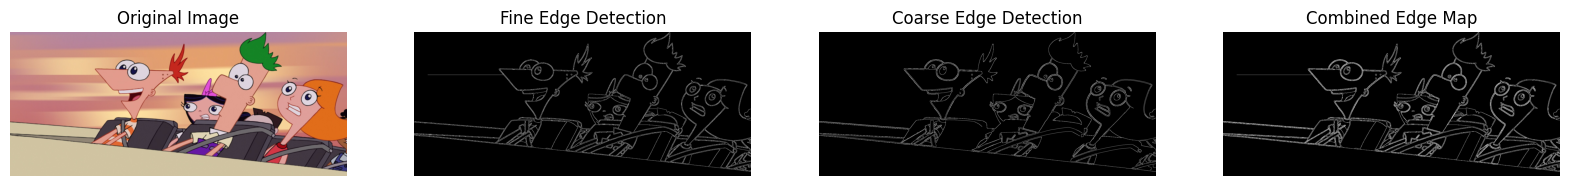

In [ ]:
# Display Results
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(fine_edges, cmap='gray')
plt.title('Fine Edge Detection')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(coarse_edges, cmap='gray')
plt.title('Coarse Edge Detection')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(combined_edges, cmap='gray')
plt.title('Combined Edge Map')
plt.axis('off')

plt.show()

# Question 3 -     3. Develop a region-based segmentation method for biomedical images, such as MRI or CT scans, using split and merge techniques.
  • Apply preprocessing (denoising, contrast enhancement).\
  • Implement region splitting based on intensity homogeneity.\
  • Merge regions using a statistical similarity test (e.g., Chi-square test).\
  • Compare the segmentation with IoU (Intersection over Union), Dice Score, Sensitivity, and Specificity.\
  • Adaptive Thresholding: Adjust variance threshold based on local contrast.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import adapted_rand_error
from scipy.stats import chi2

In [ ]:
image_org = cv2.imread('mri_scan.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
def preprocess_image(image):
    """Applies denoising and contrast enhancement."""
    denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
    enhanced = cv2.equalizeHist(denoised)
    return enhanced

In [ ]:
image = preprocess_image(image_org)

In [ ]:
def compute_variance(region):
    """Computes intensity variance of a given region."""
    return np.var(region) if region.size > 0 else 0

def split_region(image, x, y, w, h, threshold):
    """Recursively splits regions based on intensity homogeneity."""
    region = image[y:y+h, x:x+w]
    variance = compute_variance(region)

    if variance < threshold or w <= 1 or h <= 1:
        return [(x, y, w, h)]

    mid_w, mid_h = w // 2, h // 2
    return (
        split_region(image, x, y, mid_w, mid_h, threshold) +
        split_region(image, x + mid_w, y, w - mid_w, mid_h, threshold) +
        split_region(image, x, y + mid_h, mid_w, h - mid_h, threshold) +
        split_region(image, x + mid_w, y + mid_h, w - mid_w, h - mid_h, threshold)
    )

In [ ]:
# Adaptive Thresholding
global_variance = compute_variance(image)
regions = split_region(image, 0, 0, image.shape[1], image.shape[0], threshold=global_variance * 0.5)

In [ ]:
def chi_square_merge(region1, region2):
    """Computes Chi-square test for region merging."""
    hist1 = cv2.calcHist([region1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([region2], [0], None, [256], [0, 256])
    chi_sq_stat = 0.5 * np.sum((hist1 - hist2) ** 2 / (hist1 + hist2 + 1e-5))
    threshold = chi2.ppf(0.95, df=255)
    return chi_sq_stat < threshold

def evaluate_segmentation(gt_mask, segmented_mask):
    """Computes IoU, Dice Score, Sensitivity, and Specificity."""
    intersection = np.logical_and(gt_mask, segmented_mask).sum()
    union = np.logical_or(gt_mask, segmented_mask).sum()

    iou = intersection / union if union > 0 else 0
    dice = (2 * intersection) / (gt_mask.sum() + segmented_mask.sum()) if gt_mask.sum() + segmented_mask.sum() > 0 else 0

    tp = intersection
    fn = gt_mask.sum() - tp
    fp = segmented_mask.sum() - tp
    tn = gt_mask.size - (tp + fp + fn)

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return iou, dice, sensitivity, specificity

In [ ]:
# Display Split Regions
segmented_image = np.zeros_like(image)
for x, y, w, h in regions:
    segmented_image[y:y+h, x:x+w] = np.mean(image[y:y+h, x:x+w])

In [ ]:
region_labels = np.arange(len(regions)).reshape(-1, 1)

In [ ]:
while True:
    merged = False
    for i in range(len(regions)):
        for j in range(i + 1, len(regions)):
            # Check if regions i and j have the same label
            if region_labels[i] != region_labels[j]:
                x1, y1, w1, h1 = regions[i]
                x2, y2, w2, h2 = regions[j]
                region1 = image[y1:y1 + h1, x1:x1 + w1]
                region2 = image[y2:y2 + h2, x2:x2 + w2]

                # Apply Chi-square merge test
                if chi_square_merge(region1, region2):
                    region_labels[region_labels == region_labels[j]] = region_labels[i]  # Merge labels
                    merged = True

    if not merged:
        break
merged_labels_image = np.zeros_like(image, dtype=np.uint8)
for i, (x, y, w, h) in enumerate(regions):
    merged_labels_image[y:y + h, x:x + w] = region_labels[i]

In [ ]:
gt_mask = cv2.imread('ground_truth.jpg', cv2.IMREAD_GRAYSCALE)
gt_mask = gt_mask > 128
segmented_mask = segmented_image > 128

In [ ]:
# Compute Metrics
iou, dice, sensitivity, specificity = evaluate_segmentation(gt_mask, segmented_mask)

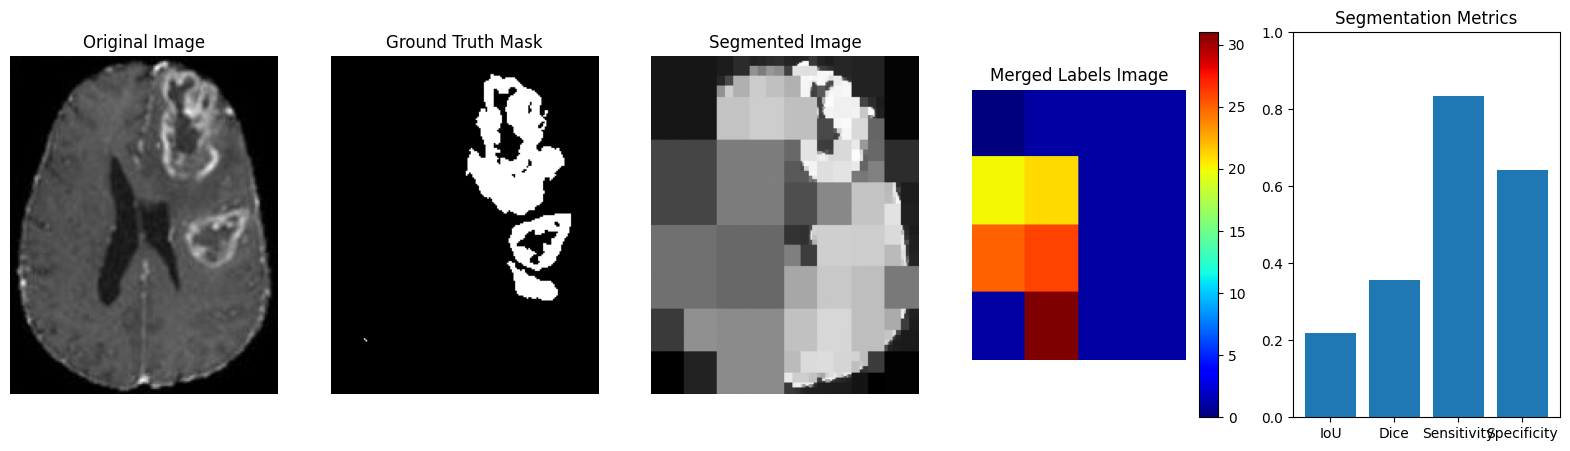

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.imshow(image_org, cmap='gray')  # Original Image
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(gt_mask, cmap='gray')  # Ground Truth
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(segmented_image, cmap='gray')  # Segmented
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(merged_labels_image, cmap='jet')
plt.title('Merged Labels Image')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 5, 5)
plt.bar(['IoU', 'Dice', 'Sensitivity', 'Specificity'], [iou, dice, sensitivity, specificity])
plt.title('Segmentation Metrics')
plt.ylim(0, 1)

plt.show()